In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import plotly.express as px
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier
import numpy as np
import joblib

In [3]:
file_path='Customer-Churn-data.csv'
churn_rate='Churn_Rate.csv'
churn_ratebycus="Churn_Rate_by_contract_type.csv"



In [4]:
df=pd.read_csv(file_path)
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [5]:
for col in df.columns:
    print(f"Unique values in column '{col}':")
    print(df[col].unique())
    print("-" * 30)

Unique values in column 'customerID':
['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
------------------------------
Unique values in column 'gender':
['Female' 'Male']
------------------------------
Unique values in column 'SeniorCitizen':
[0 1]
------------------------------
Unique values in column 'Partner':
['Yes' 'No']
------------------------------
Unique values in column 'Dependents':
['No' 'Yes']
------------------------------
Unique values in column 'tenure':
[ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39]
------------------------------
Unique values in column 'PhoneService':
['No' 'Yes']
------------------------------
Unique values in column 'MultipleLines':
['No phone service' 'No' 'Yes']
------------------------------
Unique values in column 'InternetService':
['DS

In [6]:
churn_rate=pd.read_csv(churn_rate)
churn_ratebyco=pd.read_csv(churn_ratebycus)


***# We are making vis of our sql queires now***





## 1.Churners vs Non churners

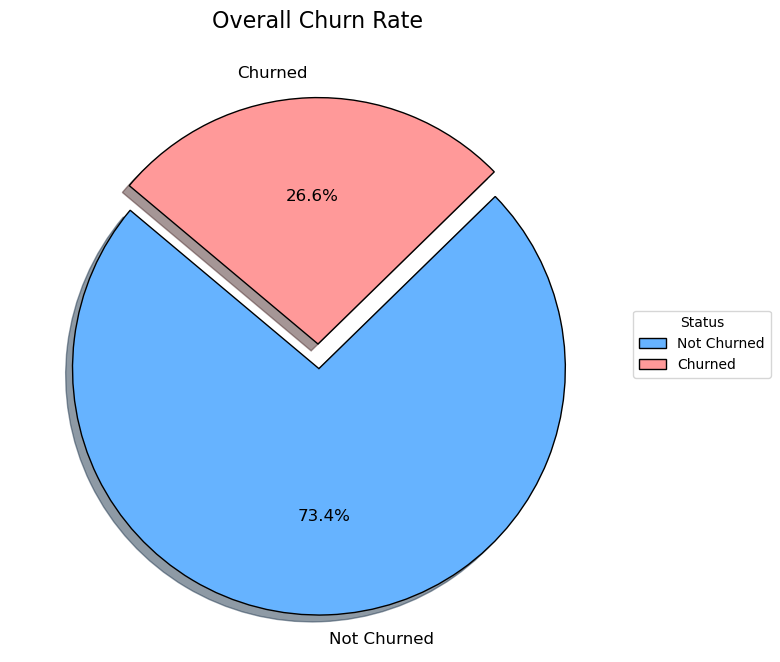

In [7]:
total=churn_rate['n'].iloc[0]
churners=churn_rate['churners'].iloc[0]
non_churners=total-churners

plot_churn=pd.DataFrame({
    'Status':['Not Churned','Churned'],
    'Count':[non_churners,churners]
})

plt.figure(figsize=(8, 8))
plt.pie(plot_churn['Count'], labels=plot_churn['Status'], autopct='%1.1f%%', startangle=140, colors=['#66b3ff', '#ff9999'], explode=(0.1, 0), shadow=True, wedgeprops={'edgecolor': 'black'}, textprops={'fontsize': 12})
plt.title("Overall Churn Rate", fontsize=16)
plt.legend(title="Status", loc="center left",bbox_to_anchor=(1, 0, 0.5, 1))




## 2.Churn by Contract rate


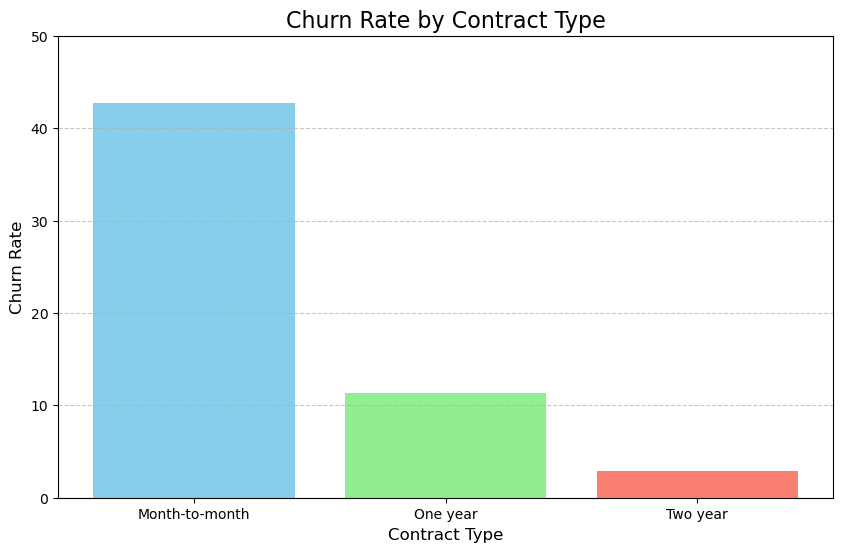

In [8]:
plt.figure(figsize=(10, 6))
plt.bar(churn_ratebyco['contract'], churn_ratebyco['churn_rate'], color=['skyblue', 'lightgreen', 'salmon'])
plt.title('Churn Rate by Contract Type', fontsize=16)
plt.xlabel('Contract Type', fontsize=12)
plt.ylabel('Churn Rate', fontsize=12)
plt.ylim(0, 50)
plt.grid(axis='y', linestyle='--', alpha=0.7)


## 3.Average Monthly Charges: Churn vs Non-Churn

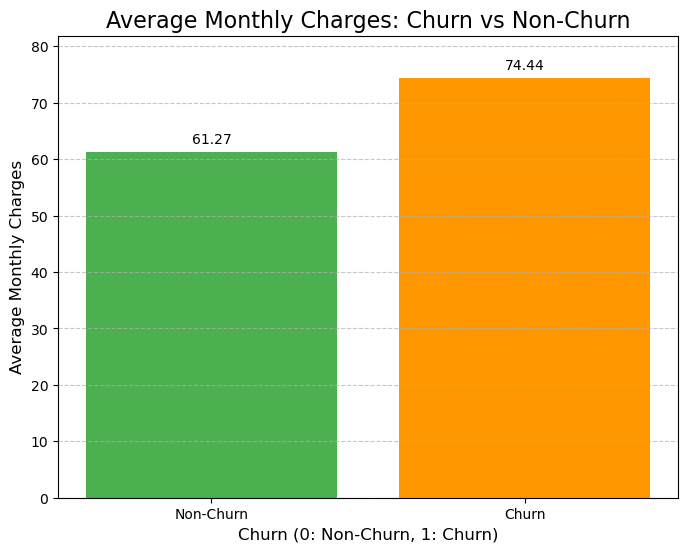

In [9]:

avg_charges = df.groupby('Churn')['MonthlyCharges'].mean().reset_index()

plt.figure(figsize=(8, 6))
bars = plt.bar(avg_charges['Churn'], avg_charges['MonthlyCharges'], color=['#4CAF50', '#FF9800'])
plt.title('Average Monthly Charges: Churn vs Non-Churn', fontsize=16)
plt.xlabel('Churn (0: Non-Churn, 1: Churn)', fontsize=12)
plt.ylabel('Average Monthly Charges', fontsize=12)
plt.ylim(0, avg_charges['MonthlyCharges'].max() * 1.1)
plt.xticks(avg_charges['Churn'], ['Non-Churn', 'Churn'])
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, round(yval, 2), ha='center', va='bottom', fontsize=10)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


###Model Training

In [10]:
yes_no_cols = ["Partner", "Dependents", "PhoneService", "MultipleLines", "OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies", "PaperlessBilling", "Churn"]

for col in yes_no_cols:
    df[col] = df[col].map({"Yes": 1, "No": 0, "No internet service": 0, "No phone service": 0})

In [11]:
df

customerID  gender  SeniorCitizen  Partner  Dependents  tenure  \
0     7590-VHVEG  Female              0        1           0       1   
1     5575-GNVDE    Male              0        0           0      34   
2     3668-QPYBK    Male              0        0           0       2   
3     7795-CFOCW    Male              0        0           0      45   
4     9237-HQITU  Female              0        0           0       2   
...          ...     ...            ...      ...         ...     ...   
7038  6840-RESVB    Male              0        1           1      24   
7039  2234-XADUH  Female              0        1           1      72   
7040  4801-JZAZL  Female              0        1           1      11   
7041  8361-LTMKD    Male              1        1           0       4   
7042  3186-AJIEK    Male              0        0           0      66   

      PhoneService  MultipleLines InternetService  OnlineSecurity  ...  \
0                0              0             DSL               0  ...   
1                1              0             DSL               1  ...   
2                1              0             DSL               1  ...   
3                0              0             DSL               1  ...   
4                1              0     Fiber optic               0  ...   
...            ...            ...             ...             ...  ...   
7038             1              1             DSL               1  ...   
7039             1              1     Fiber optic               0  ...   
7040             0              0             DSL               1  ...   
7041             1              1     Fiber optic               0  ...   
7042             1              0     Fiber optic               1  ...   

      DeviceProtection  TechSupport  StreamingTV  StreamingMovies  \
0                    0            0            0                0   
1                    1            0            0                0   
2                    0            0            0                0   
3                    1            1            0                0   
4                    0            0            0                0   
...                ...          ...          ...              ...   
7038                 1            1            1                1   
7039                 1            0            1                1   
7040                 0            0            0                0   
7041                 0            0            0                0   
7042                 1            1            1                1   

            Contract PaperlessBilling              PaymentMethod  \
0     Month-to-month                1           Electronic check   
1           One year                0               Mailed check   
2     Month-to-month                1               Mailed check   
3           One year                0  Bank transfer (automatic)   
4     Month-to-month                1           Electronic check   
...              ...              ...                        ...   
7038        One year                1               Mailed check   
7039        One year                1    Credit card (automatic)   
7040  Month-to-month                1           Electronic check   
7041  Month-to-month                1               Mailed check   
7042        Two year                1  Bank transfer (automatic)   

     MonthlyCharges  TotalCharges Churn  
0             29.85         29.85     0  
1             56.95        1889.5     0  
2             53.85        108.15     1  
3             42.30       1840.75     0  
4             70.70        151.65     1  
...             ...           ...   ...  
7038          84.80        1990.5     0  
7039         103.20        7362.9     0  
7040          29.60        346.45     0  
7041          74.40         306.6     1  
7042         105.65        6844.5     0  

[7043 rows x 21 columns]

In [30]:
df['TotalCharges']=pd.to_numeric(df["TotalCharges"],errors='coerce')
df['TotalCharges']=df["TotalCharges"].fillna(df["TotalCharges"].median())

In [31]:
x=df.drop('Churn',axis=1)
y=df['Churn']

In [32]:
clean_df = x.copy()
clean_df["Churn"] = y  # attach target back
clean_df.to_csv("clean_churn_data.csv", index=False)


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   int64  
 4   Dependents        7043 non-null   int64  
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   int64  
 7   MultipleLines     7043 non-null   int64  
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   int64  
 10  OnlineBackup      7043 non-null   int64  
 11  DeviceProtection  7043 non-null   int64  
 12  TechSupport       7043 non-null   int64  
 13  StreamingTV       7043 non-null   int64  
 14  StreamingMovies   7043 non-null   int64  
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   int64  


In [17]:



multicat_cols=['Contract', 'InternetService', 'PaymentMethod']
numeric_cols=['tenure', 'MonthlyCharges', 'TotalCharges']

preprocess=ColumnTransformer(
    transformers=[
        ('one_hot',OneHotEncoder(drop='first'),multicat_cols),
        ('scale',StandardScaler(),numeric_cols)
    ]
)




In [18]:
x_train,x_test,y_train,y_test=train_test_split(
    x,y,random_state=42,test_size=0.3)

In [19]:
x_train_processed = preprocess.fit_transform(x_train[multicat_cols + numeric_cols])
x_test_processed = preprocess.transform(x_test[multicat_cols + numeric_cols])

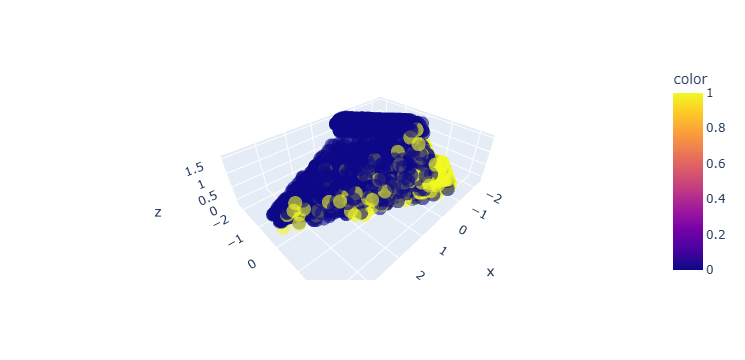

In [20]:
svd3 = TruncatedSVD(n_components=3, random_state=42)
Xtr_3D = svd3.fit_transform(x_train_processed)

fig = px.scatter_3d(
    x=Xtr_3D[:,0],
    y=Xtr_3D[:,1],
    z=Xtr_3D[:,2],
    color=y_train,
    opacity=0.6
)
fig.show()

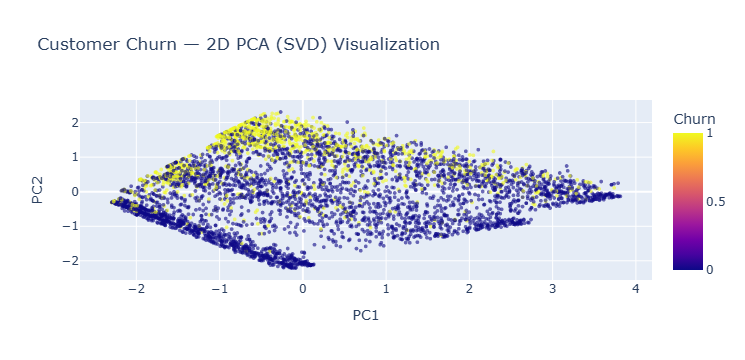

In [22]:
svd2 = TruncatedSVD(n_components=2, random_state=42)
xtr_2d = svd2.fit_transform(x_train_processed)

plot_df_2d = pd.DataFrame(xtr_2d, columns=["PC1", "PC2"])
plot_df_2d['Churn'] = y_train.reset_index(drop=True)

fig_2d = px.scatter(
    plot_df_2d, x="PC1", y="PC2",
    color="Churn",
    opacity=0.6,
    title="Customer Churn — 2D PCA (SVD) Visualization",
    labels={"PC1":"PC1", "PC2":"PC2"}
)
fig_2d.update_traces(marker=dict(size=4))
fig_2d.show()

In [23]:
logreg = LogisticRegression(
    solver='saga',
    max_iter=1000,
    class_weight='balanced',
    n_jobs=-1
)

logreg.fit(x_train_processed, y_train)
y_pred_lr = logreg.predict(x_test_processed)

print(confusion_matrix(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr, digits=3))
print(f"-"*100)

print(f"After threshold tunning to 0.4")


y_proba = logreg.predict_proba(x_test_processed)[:,1]


best_thr = 0.40
y_proba = logreg.predict_proba(x_test_processed)[:,1]
y_final = (y_proba >= best_thr).astype(int)
print(classification_report(y_test, y_final, digits=3))





[[1089  450]
 [  94  480]]
              precision    recall  f1-score   support

           0      0.921     0.708     0.800      1539
           1      0.516     0.836     0.638       574

    accuracy                          0.743      2113
   macro avg      0.718     0.772     0.719      2113
weighted avg      0.811     0.743     0.756      2113

----------------------------------------------------------------------------------------------------
After threshold tunning to 0.4
              precision    recall  f1-score   support

           0      0.950     0.604     0.738      1539
           1      0.463     0.915     0.614       574

    accuracy                          0.688      2113
   macro avg      0.706     0.759     0.676      2113
weighted avg      0.818     0.688     0.705      2113



In [24]:
xgb = XGBClassifier(
    n_estimators=400,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    eval_metric='logloss',
    tree_method='hist',
    random_state=42
)

xgb.fit(x_train_processed, y_train)
y_pred_xgb = xgb.predict(x_test_processed)

print(classification_report(y_test, y_pred_xgb, digits=3))



              precision    recall  f1-score   support

           0      0.831     0.899     0.864      1539
           1      0.653     0.510     0.573       574

    accuracy                          0.793      2113
   macro avg      0.742     0.705     0.718      2113
weighted avg      0.783     0.793     0.785      2113



In [25]:
y_proba_xgb = xgb.predict_proba(x_test_processed)[:, 1]


In [26]:
for thr in [0.50, 0.45, 0.40, 0.35, 0.30]:
    y_pred_thr = (y_proba_xgb >= thr).astype(int)

    print(f"\n--- XGBoost Threshold = {thr} ---")
    print(classification_report(y_test, y_pred_thr, digits=3))



--- XGBoost Threshold = 0.5 ---
              precision    recall  f1-score   support

           0      0.831     0.899     0.864      1539
           1      0.653     0.510     0.573       574

    accuracy                          0.793      2113
   macro avg      0.742     0.705     0.718      2113
weighted avg      0.783     0.793     0.785      2113


--- XGBoost Threshold = 0.45 ---
              precision    recall  f1-score   support

           0      0.841     0.868     0.854      1539
           1      0.613     0.559     0.585       574

    accuracy                          0.784      2113
   macro avg      0.727     0.714     0.719      2113
weighted avg      0.779     0.784     0.781      2113


--- XGBoost Threshold = 0.4 ---
              precision    recall  f1-score   support

           0      0.858     0.840     0.849      1539
           1      0.594     0.627     0.610       574

    accuracy                          0.782      2113
   macro avg      0.726     

## Feature Importance

In [27]:

ohe_features = preprocess.named_transformers_['one_hot'].get_feature_names_out(multicat_cols)
all_features = np.r_[ohe_features, numeric_cols]

importances = xgb.feature_importances_

sorted_idx = np.argsort(importances)[::-1]

for i in range(len(all_features)):
    print(f"{all_features[sorted_idx[i]]}: {importances[sorted_idx[i]]:.4f}")

Contract_Two year: 0.3845
InternetService_Fiber optic: 0.3089
Contract_One year: 0.1215
InternetService_No: 0.0548
PaymentMethod_Electronic check: 0.0312
tenure: 0.0295
MonthlyCharges: 0.0193
TotalCharges: 0.0190
PaymentMethod_Mailed check: 0.0160
PaymentMethod_Credit card (automatic): 0.0154


In [29]:

joblib.dump(preprocess, "preprocess.joblib")
joblib.dump(xgb, "modelxgb.joblib")
joblib.dump({"threshold": 0.35}, "confi.joblib")   


['confi.joblib']